In [0]:
import os
import itertools
import codecs
import re
import datetime
import editdistance
import numpy as np
import pylab
import random
import editdistance
import keras
from itertools import cycle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Input, Dense, Activation, Dropout
from keras.layers import Reshape, Lambda, Flatten
from keras.layers.merge import add, concatenate
from keras.layers.recurrent import GRU
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.utils.data_utils import get_file
from keras.preprocessing.image import ImageDataGenerator
from imageio import imread, imwrite
from PIL import Image
from matplotlib import pyplot as plt
from google.colab import drive

K.set_image_data_format('channels_last')
np.random.seed(0)

In [0]:
!ls /content/gdrive/My\ Drive/

ls: cannot access '/content/gdrive/My Drive/': No such file or directory


In [0]:
drive.mount('/content/gdrive')
folder = '/content/gdrive/My Drive/University/tfg/data/numpy_arrays/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
t_images1 = np.load(folder + "t_images.npy")
t_images2 = np.load(folder + "batchx.npy")
e_labels1 = np.load(folder + "e_labels.npy")
e_labels2 = np.load(folder + "batchye.npy")
label_lens1 = np.load(folder + "label_lens.npy")
label_lens2 = np.load(folder + "batchylen.npy")

In [0]:
# Take a test set, only from the turing sequences
turing_lines = len(t_images1)
mask = np.full(turing_lines, False)
mask[:30] = True
np.random.shuffle(mask)
t_images_test = t_images1[mask]
e_labels_test = e_labels1[mask]
label_lens_test = label_lens1[mask]
t_images1 = t_images1[~mask]
e_labels1 = e_labels1[~mask]
label_lens1 = label_lens1[~mask]

In [0]:
len(t_images1), len(t_images_test)

(369, 30)

In [0]:
# Shuffle and train test split
# t_images_train, t_images_test, e_labels_train, e_labels_test, \
#   label_lens_train, label_lens_test =  train_test_split(t_images, \
#   e_labels, label_lens, test_size=10, random_state=99)

In [0]:
t_images = np.concatenate([t_images1, t_images2], axis=0)
e_labels = np.concatenate([e_labels1, e_labels2], axis=0)
label_lens = np.concatenate([label_lens1, label_lens2], axis=0)

In [0]:
t_images.shape, e_labels.shape, label_lens.shape

((986, 170, 30, 1), (986, 19), (986, 1))

In [0]:
t_images_train, e_labels_train, label_lens_train = \
  shuffle(t_images, e_labels, label_lens, random_state=0)

In [0]:
# Load alphabet
folder = '/content/gdrive/My Drive/University/tfg/data/numpy_arrays/'
with open(folder + 'alphabet.pickle', 'rb') as handle:
  alphabet = pickle.load(handle)
with open(folder + 'ixchar.pickle', 'rb') as handle:
  ix_to_char = pickle.load(handle)

In [0]:
# Data Parameters 
img_h = t_images.shape[2]
img_w = t_images.shape[1]
input_shape = (img_w, img_h, 1)
max_string_len = max([length for length in label_lens])


# Network parameters
conv_filters = 32
num_convs = 2
kernel_size = (3,3)
pool_size = 2
time_dense_size = 64
rnn1_size = 156
rnn2_size = 256
ctc_cut = 2
output_size = len(alphabet) + 1
act = 'relu'

In [0]:
# A tensor where all values are the same, is required by ctc loss
ctc_input_length = (img_w // (pool_size ** num_convs)) - ctc_cut
ctc_input_length = np.expand_dims(np.array([ctc_input_length] * len(t_images)), 1)
ctc_input_length.shape

(986, 1)

In [0]:
def label_to_text(ixes):
  ret = []
  for c in ixes:
    if c == len(alphabet) or c == -1:  # CTC Blank
      ret.append("")
    else:
      ret.append(ix_to_char[c])
  return "".join(ret)

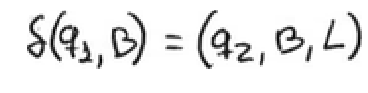

The label is:  d(q1,B)=(q2,B,L)
Should match:  [16.] 16


In [0]:
# Explore the data, check that everything is correct
i = random.randint(0, len(t_images_train)-1)
plt.imshow(np.squeeze(t_images_train[i].T), cmap='gray')
plt.axis('off')
plt.show()
print("The label is: ", label_to_text(e_labels_train[i]))
print("Should match: ", label_lens_train[i], len(label_to_text(e_labels_train[i])))

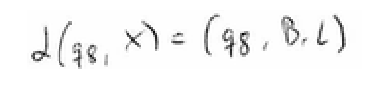

The label is:  d(q8,X)=(q8,B,L)


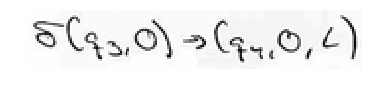

The label is:  d(q3,0)=(q4,0,L)


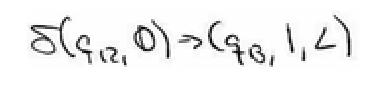

The label is:  d(q12,0)=(q13,1,L)


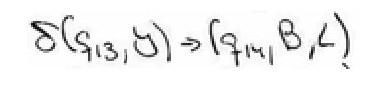

The label is:  d(q13,Y)=(q14,B,L)


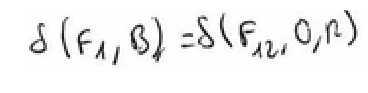

The label is:  d(F1,B)=d(F12,0,R)


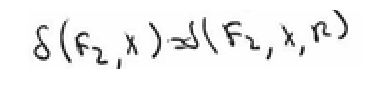

The label is:  d(F2,X)=d(F2,X,R)


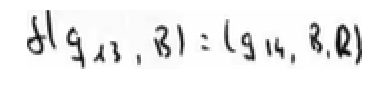

The label is:  d(q13,B)=(q14,B,R)


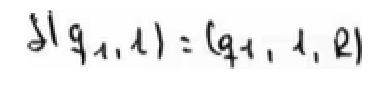

The label is:  d(q1,1)=(q1,1,R)


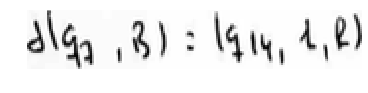

The label is:  d(q7,B)=(q14,1,R)


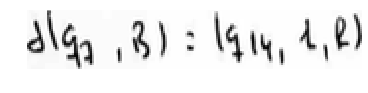

The label is:  d(q7,B)=(q14,1,R)


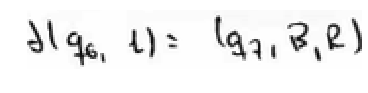

The label is:  d(q6,1)=(q7,B,R)


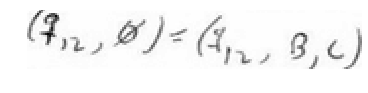

The label is:  (q12,0)=(q12,B,L)


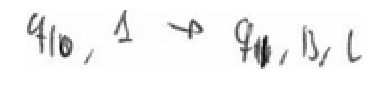

The label is:  q10,1=q11,B,L


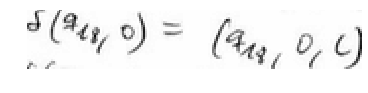

The label is:  d(q18,0)=(q18,0,L)


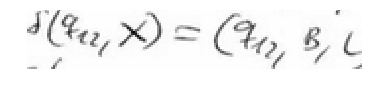

The label is:  d(q12,X)=(q12,B,L)


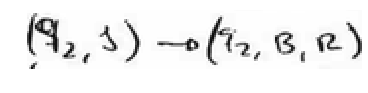

The label is:  d(q2,1)=(q2,B,R)


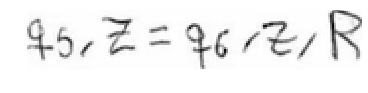

The label is:  q5,Z=q6,Z,R


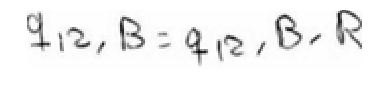

The label is:  q12,B=q12,B,R


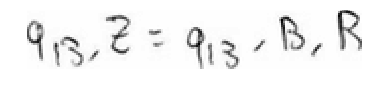

The label is:  q13,Z=q13,B,R


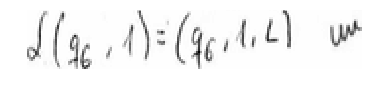

The label is:  d(q6,1)=(q6,1,L)


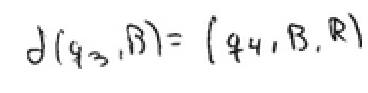

The label is:  d(q3,B)=(q4,B,R)


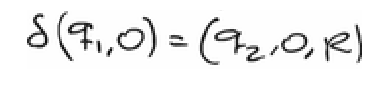

The label is:  d(q1,0)=(q2,0,R)


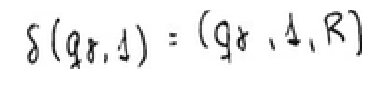

The label is:  d(q8,1)=(q8,1,R)


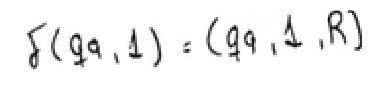

The label is:  d(q9,1)=(q9,1,R)


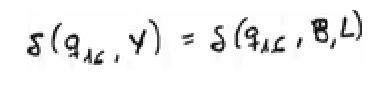

The label is:  d(q16,Y)=d(q16,B,L)


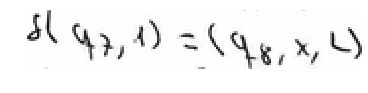

The label is:  d(q7,1)=(q8,X,L)


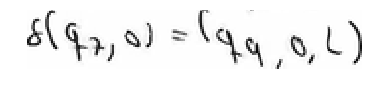

The label is:  d(q7,0)=(q9,0,L)


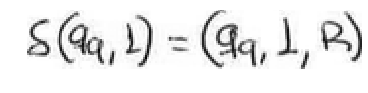

The label is:  d(q9,1)=(q9,1,R)


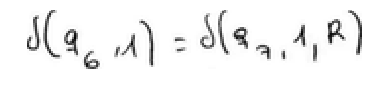

The label is:  d(q6,1)=d(q7,1,R)


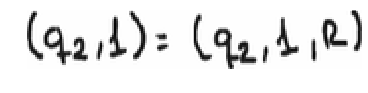

The label is:  (q2,1)=(q2,1,R)


In [0]:
# Show all test images
for i in range(len(t_images_test)):
  plt.imshow(np.squeeze(t_images_test[i].T), cmap='gray')
  plt.axis('off')
  plt.show()
  print("The label is: ", label_to_text(e_labels_test[i]))

In [0]:
# The loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, ctc_cut:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [0]:
# Define the model
input_data = Input(name='input', shape=input_shape, dtype='float32')
conv1 = Conv2D(conv_filters, kernel_size, padding='same',
               activation=act, kernel_initializer='he_normal',
               name='conv1')(input_data)
conv1 = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(conv1)
conv1 = Dropout(0.2)(conv1)
conv2 = Conv2D(conv_filters, kernel_size, padding='same',
               activation=act, kernel_initializer='he_normal',
               name='conv2')(conv1)
conv2 = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(conv2)
conv2 = Dropout(0.2)(conv2)


# conv1shape = (img_w // (pool_size ** (num_convs - 1)),
#                     (img_h // (pool_size ** (num_convs - 1))) * conv_filters)
conv2shape = (img_w // (pool_size ** num_convs),
                    (img_h // (pool_size ** num_convs)) * conv_filters)

# Failed attempt to do a skip connection

# conv1 = Reshape(target_shape=conv1shape)(conv1)
# conv2 = Reshape(target_shape=conv2shape)(conv2)
# inner = concatenate([conv1, conv2], axis=2)

inner = Reshape(target_shape=conv2shape, name='reshape')(conv2)

# cuts down input size going into RNN:
inner = Dense(time_dense_size, activation=act, name='dense1')(inner)

# Recurrent layers
gru_1 = GRU(rnn1_size, return_sequences=True,
            kernel_initializer='he_normal', name='gru1')(inner)
gru_1b = GRU(rnn1_size, return_sequences=True,
             go_backwards=True, kernel_initializer='he_normal',
             name='gru1_b')(inner)
gru1_merged = add([gru_1, gru_1b])
# gru_2 =  GRU(rnn2_size, return_sequences=True,
#             kernel_initializer='he_normal',   name='gru2')(gru1_merged)
# gru_2b = GRU(rnn2_size, return_sequences=True, go_backwards=True,
#             kernel_initializer='he_normal', name='gru2_b')(gru1_merged)

# transforms RNN output to character activations:
inner = Dense(output_size, kernel_initializer='he_normal',
              name='dense2')(
#       concatenate([gru_2, gru_2b])
      gru1_merged
)

y_pred = Activation('softmax', name='softmax')(inner)
output_labels = Input(name='the_labels',
               shape=[max_string_len], dtype='float32')
input_lengths = Input(name='input_length', shape=[1], dtype='int64')
label_lengths = Input(name='label_length', shape=[1], dtype='int64')

# Keras doesn't currently support loss funcs with extra parameters
# so CTC loss is implemented in a lambda layer
loss_out = Lambda(
    ctc_lambda_func, output_shape=(1,),
    name='ctc')([y_pred, output_labels, input_lengths, label_lengths])
model = Model(inputs=[input_data, output_labels, input_lengths, label_lengths],
                  outputs=loss_out)

model.summary()

In [0]:
# Decoder model 
top_k_dec_list, _ = K.ctc_decode(y_pred[:, ctc_cut:, :], K.squeeze(input_lengths, axis=1), greedy=False, top_paths=3)
decoder0 = K.function([input_data, input_lengths], [top_k_dec_list[0]])
decoder1 = K.function([input_data, input_lengths], [top_k_dec_list[1]])
decoder2 = K.function([input_data, input_lengths], [top_k_dec_list[2]])

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [0]:
t_images.shape, e_labels.shape, ctc_input_length.shape, label_lens.shape

((986, 170, 30, 1), (986, 19), (986, 1), (986, 1))

In [0]:
# Data Augmentation
data_gen_args = dict(
    rotation_range = 2,
    #width_shift_range = 2,
    #height_shift_range = 2,
    #zoom_range = 0.05,
    shear_range = 8,
    data_format = 'channels_last',
)
image_datagen = ImageDataGenerator(**data_gen_args)
image_flow = image_datagen.flow(t_images_train, batch_size=1, shuffle=False)

In [0]:
def get_data_round():
  image_round = []
  for _ in range(len(t_images_train)):
    image_round.append(np.squeeze(next(image_flow),axis=0))
  return [image_round, e_labels_train, ctc_input_length[:len(t_images_train)], 
          label_lens_train]

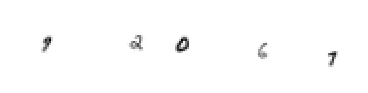

92067


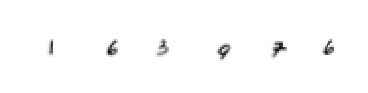

163976


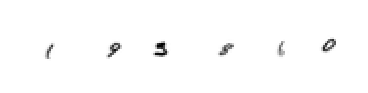

195860


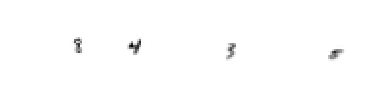

8435


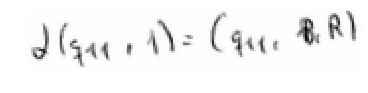

d(q11,1)=(q11,B,R)


In [0]:
# Testing the data comming from the generator
testing_imgs, testing_lbs, _, _ = get_data_round()
r = random.randint(0, len(t_images) - 6)
for i in range(r, r+5):
  img = testing_imgs[i]
  plt.imshow(np.squeeze(img.T), cmap='gray')
  plt.axis('off')
  plt.show()
  print(label_to_text(testing_lbs[i]))

In [0]:
# Edit distance metric ...
def edit_distance(y_true, y_pred):
  total = 0
  for true, pred in zip(y_true, y_pred):
    true = label_to_text(list(np.squeeze(true)))
    pred = label_to_text(list(np.squeeze(pred)))
    total += editdistance.eval(true, pred)
  return total / len(y_true)

In [0]:
number = 16
# model.load_weights(f'/content/gdrive/My Drive/University/tfg/model_saves/model_{number}.h5')

In [0]:
i = 0

In [0]:
# For initial stages
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr=0.001))

In [0]:
# First approximation
history = model.fit(
        x = get_data_round(),
        y = np.zeros(len(t_images_train)),
        batch_size=128,
        epochs=20,
        verbose=0,
        #validation_split=0.15,
)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [0]:
# For long training
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr=0.0001))

In [0]:
# Long training
for j in range(150):
  data_round = get_data_round()
  history = model.fit(
          x = data_round,
          y = np.zeros(len(t_images_train)),
          batch_size=64,
          epochs=5,
          verbose=0,
          validation_split=0.2,
          shuffle=False,
         )
  print(f"Iteration {j:0>2}: loss: {np.min(history.history['loss']):5.2f}, validation loss: {np.min(history.history['val_loss']):5.2f}")
  if (j+1) % 10 == 0:
    i += 1
    print(f"Saving weights, model: {i}!")
    # model.save_weights(f'/content/gdrive/My Drive/University/tfg/model_saves/modelnew_{i}.h5')

In [0]:
# For final stages
sgd = SGD(lr=0.0001, 
          momentum=0.5,
          nesterov=True, 
          clipnorm=5,
          # decay = 1e-6,
          )
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)

In [0]:
# Fine-grained descent (TM)
history = model.fit(
        x = get_data_round(),
        y = np.zeros(len(t_images_train)),
        batch_size=32,
        epochs=20,
        verbose=2,
        #validation_split=0.2,
)

In [0]:
i += 1
print(f"Saving weights, model: {i}!")
model.save_weights(f'/content/gdrive/My Drive/University/tfg/model_saves/model_{i}.h5')

In [0]:
# Save final model for production
model.save('/content/gdrive/My Drive/University/tfg/backend/production_model.h5')

In [0]:
keras.models.load_model('/content/gdrive/My Drive/University/tfg/backend/production_model.h5')

In [0]:
model_json = model.to_json()
with open('/content/gdrive/My Drive/University/tfg/backend/production_model.json', 'w') as json_file:
    json_file.write(model_json)

In [0]:
# Look at the test results
total_edit_distance = 0
for j in range(len(t_images_test)):
  plt.imshow(np.squeeze(t_images_test[j].T), cmap='gray')
  plt.axis('off')
  plt.show()
  decoded0 = decoder0([t_images_test[j:j+1], ctc_input_length[j:j+1]])
  decoded1 = decoder1([t_images_test[j:j+1], ctc_input_length[j:j+1]])
  decoded2 = decoder2([t_images_test[j:j+1], ctc_input_length[j:j+1]])
  print("True label:   ", label_to_text(list(np.squeeze(e_labels_test[j]))))
  print("Prediction 1: ", label_to_text(list(np.squeeze(decoded0))))
  print("Prediction 2: ", label_to_text(list(np.squeeze(decoded1))))
  print("Prediction 3: ", label_to_text(list(np.squeeze(decoded2))))
  distance = editdistance.eval(label_to_text(e_labels_test[j]),
                      label_to_text(list(np.squeeze(decoded0))))
  total_edit_distance += distance
  print(f"Edit distance: {distance}")

print(f"Average test edit distance: {total_edit_distance / len(t_images_test)}")

In [0]:
# Compute training dataset edit distance
total_edit_distance = 0
for j in range(len(t_images_train)):
  decoded0 = decoder0([t_images_train[j:j+1], ctc_input_length[j:j+1]])[0]
  true = label_to_text(list(np.squeeze(e_labels_train[j])))
  if decoded0.size:
    predicted = label_to_text(list(np.squeeze(decoded0, axis=0)))
  else:
    predicted = ""
  distance = editdistance.eval(true, predicted)
  total_edit_distance += distance
  
print(f"Average training edit distance: {total_edit_distance / len(t_images_train)}")

In [0]:
# Compute training dataset edit distance (in batch, WIP)
total_edit_distance = 0
decoded0 = decoder0([t_images_train, ctc_input_length[:len(t_images_train)]])[0]
trues = []
preds = []
for label in list(np.squeeze(e_labels_train[j])):
  trues.append(label_to_text(label))
for dec in decoded0:
  preds.append(label_to_text(list(dec)))

for true, pred in trues, preds:
  distance = editdistance.eval(true, pred)
  total_edit_distance += distance
  
print(f"Average edit distance: {total_edit_distance / len(t_images_train)}")